# Cell type annotation from marker genes

In single-cell, we have no prior information of which cell type each cell belongs.
To assign cell type labels, we first project all cells in a shared embedded space, 
then we find communities of cells that show a similar transcription profile and finally
we check what cell type specific markers are expressed. If more than one marker
gene is available, statistical methods can be used to test if a set of markers is
enriched in a given cell population.

In this notebook we showcase how to use `decoupler` for cell type annotation with the 3k PBMCs 10X data-set. The data consists of 3k PBMCs from a Healthy Donor and is freely available
from 10x Genomics [here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz)
from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)

<div class="alert alert-info">

**Note**
    
This tutorial assumes that you already know the basics of `decoupler`. Else, check out the **Usage** tutorial first.

</div>  

## Loading packages

First, we need to load the relevant packages, `scanpy` to handle scRNA-seq data
and `decoupler` to use statistical methods.

In [1]:
import scanpy as sc
import decoupler as dc

# Only needed for visualization:
import matplotlib.pyplot as plt
import seaborn as sns

## Single-cell processing

### Loading the data-set

We can download the data easily using `scanpy`:

In [2]:
adata = sc.datasets.pbmc3k()
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

### QC, projection and clustering


Here we follow the standard pre-processing steps as described in the [scanpy vignette](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).
These steps carry out the selection and filtration of cells based on 
quality control metrics, the data normalization and scaling, and the detection of 
highly variable features. 

<div class="alert alert-info">

**Note**
    
This is just an example, these steps should change depending on the data.

</div> 

In [3]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var_names.str.startswith('MT-')  
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Filter cells following standard QC criteria.
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Identify the 2000 most highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Filter higly variable genes
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

# Regress and scale the data
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

/home/badi/miniconda3/envs/decoupler/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Then we group cells based on the similarity of their transcription profiles. 
To visualize the communities we perform UMAP reduction.

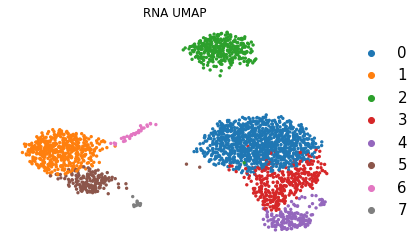

In [4]:
# Generate PCA features
sc.tl.pca(adata, svd_solver='arpack')

# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Generate UMAP features
sc.tl.umap(adata)

# Run leiden clustering algorithm
sc.tl.leiden(adata)

# Visualize
sc.pl.umap(adata, color='leiden', title='RNA UMAP', 
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

At this stage, we have identified communities of cells that show a similar 
transcriptomic profile, and we would like to know to which cell type they 
probably belong.

## Marker genes

To annotate single cell clusters, one can use cell type specific marker genes. 
These are genes that are mainly expressed exclusively by a specific cell type, 
making them useful to distinguish heterogeneous groups of cells. Marker genes were
discovered and annotated in previous studies and there are some resources that
collect and curate them.

[Omnipath](https://omnipathdb.org/) is one of the largest available databases of 
curated prior knowledge. Among its resources, there is 
[PanglaoDB](https://panglaodb.se/), a database of cell type markers, 
which can be easily accessed using a wrapper to Omnipath from `decoupler`. 

<div class="alert alert-info">

**Note**
    
If you encounter bugs with `Omnipath`, sometimes is good to just remove its cache using: `rm $HOME/.cache/omnipathdb/*` 

</div> 

In [5]:
# Query Omnipath and get PanglaoDB
markers = dc.get_resource('PanglaoDB')
markers

label,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
0,CTRB1,False,Enterocytes,Endoderm,True,0.0,0.00439422,True,0.00331126,0.0204803,9606,GI tract,0.017
1,CTRB1,True,Acinar cells,Endoderm,True,1.0,0.000628931,True,0.957143,0.0159201,9606,Pancreas,0.017
2,KLK1,True,Acinar cells,Endoderm,True,0.833333,0.00503145,True,0.314286,0.0128263,9606,Pancreas,0.013
3,KLK1,False,Goblet cells,Endoderm,True,0.588235,0.00503937,True,0.903226,0.0124084,9606,GI tract,0.013
4,KLK1,False,Epithelial cells,Mesoderm,True,0.0,0.00823306,True,0.225806,0.0137585,9606,Epithelium,0.013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8472,SLC14A1,True,Urothelial cells,Mesoderm,True,0.0,0.0181704,True,0.0,0.0,9606,Urinary bladder,0.008
8473,UPK3A,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0
8474,UPK1A,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0
8475,UPK2,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0


Since our data-set is from human cells, and we want best quality of the markers, we can filter by `canonical_marker` and `human`:

In [6]:
# Filter by canonical_marker and human
markers = markers[(markers['human']=='True')&(markers['canonical_marker']=='True')]

# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers

label,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
1,CTRB1,True,Acinar cells,Endoderm,True,1.0,0.000628931,True,0.957143,0.0159201,9606,Pancreas,0.017
2,KLK1,True,Acinar cells,Endoderm,True,0.833333,0.00503145,True,0.314286,0.0128263,9606,Pancreas,0.013
5,KLK1,True,Principal cells,Mesoderm,True,0.0,0.00814536,True,0.285714,0.0140583,9606,Kidney,0.013
7,KLK1,True,Plasmacytoid dendritic cells,Mesoderm,True,0.0,0.00820189,True,1.0,0.0129136,9606,Immune system,0.013
8,KLK1,True,Endothelial cells,Mesoderm,True,0.0,0.00841969,True,0.0,0.0149153,9606,Vasculature,0.013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8472,SLC14A1,True,Urothelial cells,Mesoderm,True,0.0,0.0181704,True,0.0,0.0,9606,Urinary bladder,0.008
8473,UPK3A,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0
8474,UPK1A,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0
8475,UPK2,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0


For this example we will use these markers, but any collection of genes could be used. To see the list of available resources inside `Omnipath`, run `dc.show_resources()`

## Enrichment with Over Representation Analysis

To test if a collection of genes are enriched in a given cell type, we will run
Over Representation Analysis (`ora`), also known as Fisher exact test, implemented
in `decoupler`.

`ora` selects the top 5% expressed genes for each cell, and tests if a collection
of marker genes are enriched in the top expressed collection.

To run `decoupler` methods, we need an input matrix (`mat`), an input prior knowledge
network/resource (`net`), and the name of the columns of `net` that we want to use.

In [7]:
dc.run_ora(mat=adata, net=markers, source='cell_type', target='genesymbol', min_n=3, verbose=True)

58 features of mat are empty in 2635 samples, they will be ignored.
Running ora on mat with 2638 samples and 13656 targets for 114 sources.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2638/2638 [00:02<00:00, 989.51it/s]


The obtained scores (-log10(p-value))(`ora_estimate`) and p-values (`ora_pvals`) are stored in the `.obsm` key:

In [8]:
adata.obsm['ora_estimate']

source,Acinar cells,Adipocytes,Airway goblet cells,Alpha cells,Alveolar macrophages,Astrocytes,B cells,B cells memory,B cells naive,Basophils,...,T cells,T follicular helper cells,T helper cells,T regulatory cells,Tanycytes,Taste receptor cells,Thymocytes,Trophoblast cells,Tuft cells,Urothelial cells
AAACATACAACCAC-1,0.497959,0.318480,-0.0,1.446730,0.886826,0.197098,2.966246,2.040227,0.928107,-0.000000,...,11.103040,-0.0,1.040001,-0.000000,-0.000000,-0.0,1.532791,-0.000000,1.040001,-0.000000
AAACATTGAGCTAC-1,0.497959,0.665563,-0.0,0.570906,-0.000000,0.197098,5.719522,9.792773,12.849517,0.090592,...,1.204336,-0.0,0.391150,-0.000000,-0.000000,-0.0,0.300110,0.886826,1.876995,-0.000000
AAACATTGATCAGC-1,0.497959,0.665563,-0.0,1.446730,0.886826,0.584060,0.934609,2.684658,4.029775,1.093264,...,8.823756,-0.0,-0.000000,-0.000000,0.665675,-0.0,2.374529,-0.000000,1.876995,-0.000000
AAACCGTGCTTCCG-1,1.282176,2.997417,-0.0,1.446730,0.886826,0.584060,1.515196,0.263925,0.928107,0.090592,...,0.722540,-0.0,-0.000000,-0.000000,-0.000000,-0.0,0.300110,0.886826,3.985677,-0.000000
AAACCGTGTATGCG-1,-0.000000,-0.000000,-0.0,0.570906,0.886826,-0.000000,0.934609,0.074781,0.069323,1.631113,...,3.174191,-0.0,1.040001,-0.000000,0.665675,-0.0,0.300110,-0.000000,0.391150,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,1.282176,1.666912,-0.0,1.446730,0.886826,0.584060,2.966246,0.566965,2.590705,0.308558,...,1.204336,-0.0,0.391150,-0.000000,0.665675,-0.0,1.532791,-0.000000,1.040001,0.797255
TTTCTACTGAGGCA-1,-0.000000,-0.000000,-0.0,2.544419,0.886826,0.197098,1.515196,1.466532,1.406718,0.308558,...,0.722540,-0.0,-0.000000,0.570906,0.665675,-0.0,0.300110,-0.000000,1.040001,-0.000000
TTTCTACTTCCTCG-1,-0.000000,-0.000000,-0.0,1.446730,-0.000000,0.197098,10.246682,10.880681,14.024753,0.090592,...,1.780892,-0.0,0.391150,-0.000000,-0.000000,-0.0,3.334413,-0.000000,1.040001,-0.000000
TTTGCATGAGAGGC-1,-0.000000,0.094177,-0.0,0.570906,-0.000000,0.197098,5.719522,5.853269,9.540698,-0.000000,...,0.722540,-0.0,0.391150,0.570906,-0.000000,-0.0,1.532791,-0.000000,1.040001,-0.000000


## Visualization

To visualize the obtianed scores, we can re-use many of `scanpy`'s plotting functions.
First though, we need to extract the activities from the `adata` object.

In [9]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')
acts

AnnData object with n_obs × n_vars = 2638 × 114
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals'

`dc.get_acts` returns a new `AnnData` object which holds the obtained activities in its `.X` attribute, allowing us to re-use many `scanpy` functions, for example:

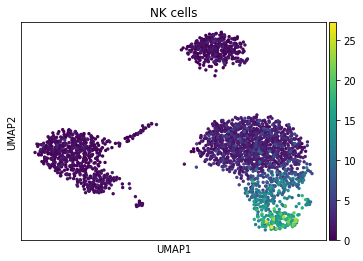

In [10]:
sc.pl.umap(acts, color='NK cells')

The cells highlighted seem to be enriched by NK cell marker genes.

## Annotation

With `decoupler` we can also see what is the mean enrichment per group, in our case the cluster groups obtained from clustering:

In [11]:
mean_enr = dc.summarize_acts(acts, groupby='leiden', min_std=1)
mean_enr

,B cells,B cells memory,B cells naive,Dendritic cells,Gamma delta T cells,Macrophages,Megakaryocytes,Microglia,Monocytes,NK cells,Neutrophils,Plasma cells,Platelets,T cells
0,1.420094,1.140389,1.746298,2.821328,1.092981,0.608217,0.560921,0.700223,1.868247,1.826654,0.744151,1.061873,2.101722,7.317633
1,1.403896,0.481573,1.110922,11.892812,0.363242,4.700076,1.004909,3.135547,6.661194,0.565005,4.162921,1.009368,2.952116,1.119892
2,6.757785,7.118757,11.472005,7.546385,0.425376,0.595165,0.468223,1.014946,1.590680,0.633051,0.609377,4.045681,2.012075,2.223654
3,1.331953,0.962592,1.360179,3.618775,4.538346,1.026256,0.738036,0.853198,1.828143,7.566985,0.701345,1.143512,2.729565,9.043226
4,0.861358,0.592330,0.963177,3.403950,11.276625,1.608084,0.963142,1.170007,2.449554,15.116052,1.282446,1.177690,3.056254,5.592730
5,2.102295,0.640831,1.266570,11.857082,0.638654,5.096111,0.742058,3.416046,6.478490,0.774518,2.851544,0.932343,3.452569,1.297751
6,1.872337,0.891041,2.281030,13.363841,0.725884,3.335606,0.618584,2.545460,4.209533,0.610389,2.276198,1.930163,2.791891,1.414323
7,0.573362,0.289568,0.487174,2.342902,0.813862,0.993497,5.811973,1.135146,0.571878,0.516215,0.632475,0.766886,23.921930,0.663608


We can visualize which cell types are more enriched for each cluster using `seaborn`:

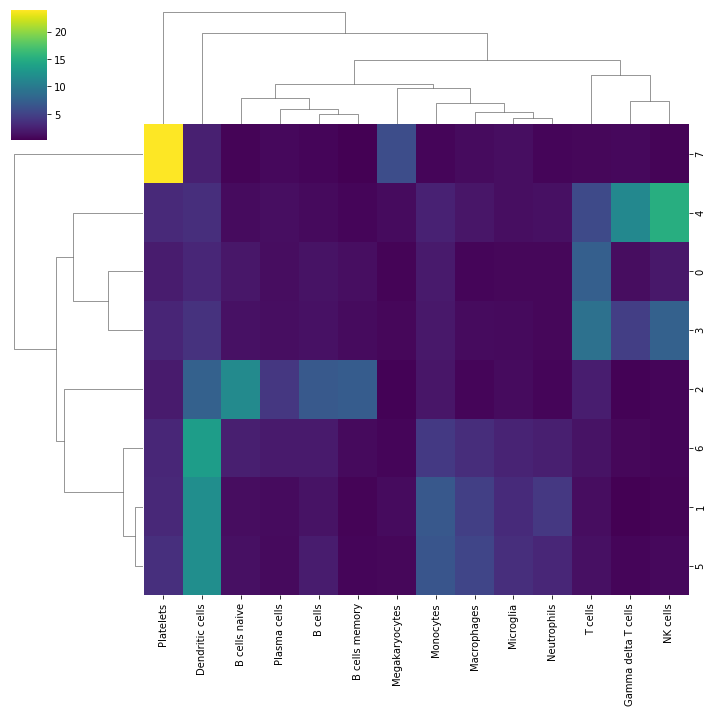

In [12]:
sns.clustermap(mean_enr, xticklabels=mean_enr.columns, cmap='viridis')
plt.show()

From this plot we see that cluster 7 belongs to Platelets, cluster 4 appear to be NK cells, custers 0 and 3 might be T-cells, cluster 2 should be some sort of B cells and that clusters 6,5 and 1 are Dendritic cells or Monocytes

We can also get what is the maximum value per group:

In [13]:
annotation_dict = dc.assign_groups(mean_enr)
annotation_dict

{'0': 'T cells',
 '1': 'Dendritic cells',
 '2': 'B cells naive',
 '3': 'T cells',
 '4': 'NK cells',
 '5': 'Dendritic cells',
 '6': 'Dendritic cells',
 '7': 'Platelets'}

Which we can use to annotate our data-set:

/home/badi/miniconda3/envs/decoupler/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical


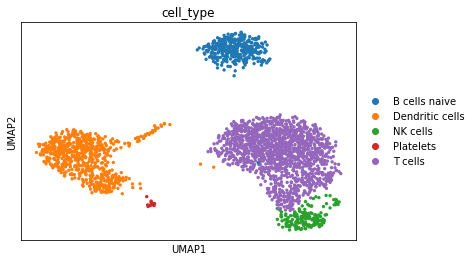

In [14]:
# Add cell type column based on annotation
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

# Visualize
sc.pl.umap(adata, color='cell_type')

Compared to the annotation obtained by the `scanpy` tutorial, it is very simmilar.

![scanpy_annotation](https://scanpy-tutorials.readthedocs.io/en/latest/_images/pbmc3k_100_1.png)